Erstmal alle Imports klären:

In [ ]:
pip install shapely

In [1]:
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import glob
import os 

# lokale imports
from utils import euklidean_distance
from config import FPS

Alle Funktionen die nicht im Maincode gebraucht werden:

In [2]:

def create_polygon(polygon_coords=list):
    return Polygon(polygon_coords)

def create_point(x, y):
    return Point(x, y)

def is_point_in_polygon(polygon, point):
    return polygon.contains(point)

Feste Variablen:

In [12]:
arena_coords = [(110,20), (1870,25), (1860,1070), (110,1070)]
enter_zone_coords = [(1700,430),(1900,430),(1900,670),(1700,670)]

Ordner mit H5 Dateien wird eingelesen:

In [13]:
path = r"C:\Users\quicken\Code\Ambros_analysis\code_test"
#path = r"C:\Users\Fabian\Code\Ambros_analysis\code_test"
file_list = glob.glob(os.path.join(path, '*.h5'))

df_list = [pd.read_hdf(f) for f in file_list]

for file in file_list:
    with pd.HDFStore(file, mode='r') as store:
        print(store.keys())


scorer_list = [df.columns.levels[0][0] for df in df_list]
individuals_list = [df.columns.levels[1].to_list() for df in df_list]
bodyparts_list = [df.columns.levels[2].to_list() for df in df_list]

print(file_list)


['/tracks']
['C:\\Users\\quicken\\Code\\Ambros_analysis\\code_test\\2025_07_09_14_29_58_3_mice_bedding_control_top2_40405188DLC_DekrW18_3_mice_mergedJul25shuffle1_snapshot_best-280_el.h5']


In [14]:
# da die h5 verändert werden, wird einmal die ursprüngliche Version gespeichert
for idx, df in enumerate(df_list):
    filename = os.path.basename(file_list[idx])
    filename = filename.rsplit('.')

    # build savepath
    save_as = os.path.join(path, filename[0] + '_old.h5')
    df.to_hdf(save_as, key='tracks')
    


In [47]:
test_df = df_list[-1]
scorer = scorer_list[-1]
bodyparts = bodyparts_list[-1]
individuals = individuals_list[-1]



#for ind 1

arr_x = test_df.loc[:, (scorer, individuals[2], bodyparts, ["x", "y"])].values[:,::2]
arr_y = test_df.loc[:, (scorer, individuals[2], bodyparts, ["x", "y"])].values[:,1::2]

mean_x = np.nanmean(arr_x, axis=1)
mean_y = np.nanmean(arr_y, axis=1)

mouse_center = []

for i in range(len(mean_x)):
    point = (mean_x[i], mean_y[i])
    mouse_center.append(point)



C:\Users\quicken\AppData\Local\Temp\ipykernel_23004\3598144337.py:13: RuntimeWarning: Mean of empty slice
  mean_x = np.nanmean(arr_x, axis=1)
C:\Users\quicken\AppData\Local\Temp\ipykernel_23004\3598144337.py:14: RuntimeWarning: Mean of empty slice
  mean_y = np.nanmean(arr_y, axis=1)


In [ ]:
test_df

interpolation sollte ggf erst nach der restlichen curation der prediction stattfinden?

In [16]:
def interpolate_with_max_gap(df, max_gap=30, method="linear"):
    out = df.copy()
    num_cols = out.select_dtypes(include=[np.number]).columns
    print(num_cols)

    # 1) Nur „echte“ Interpolation zwischen gültigen Punkten
    out[num_cols] = out[num_cols].interpolate(method=method,
                                              limit_direction="both",
                                              limit_area="inside")
    
    # 2) NaN-Runs > max_gap identifizieren und wieder auf NaN setzen
    for col in num_cols:
        s = df[col]  # Original mit NaNs
        # Gruppen-IDs zwischen Nicht-NaNs erstellen
        grp = s.notna().cumsum()
        # Länge jedes NaN-Runs
        run_len = s.isna().groupby(grp).transform("sum")
        # Maske: Positionen in zu langen NaN-Runs
        too_long = s.isna() & (run_len > max_gap)
        # Zurücksetzen
        out.loc[too_long, col] = np.nan
    
    return out
    
test_df = interpolate_with_max_gap(test_df, max_gap=30)

MultiIndex([('DLC_DekrW18_3_mice_mergedJul25shuffle1_snapshot_best-280', ...),
            ('DLC_DekrW18_3_mice_mergedJul25shuffle1_snapshot_best-280', ...),
            ('DLC_DekrW18_3_mice_mergedJul25shuffle1_snapshot_best-280', ...),
            ('DLC_DekrW18_3_mice_mergedJul25shuffle1_snapshot_best-280', ...),
            ('DLC_DekrW18_3_mice_mergedJul25shuffle1_snapshot_best-280', ...),
            ('DLC_DekrW18_3_mice_mergedJul25shuffle1_snapshot_best-280', ...),
            ('DLC_DekrW18_3_mice_mergedJul25shuffle1_snapshot_best-280', ...),
            ('DLC_DekrW18_3_mice_mergedJul25shuffle1_snapshot_best-280', ...),
            ('DLC_DekrW18_3_mice_mergedJul25shuffle1_snapshot_best-280', ...),
            ('DLC_DekrW18_3_mice_mergedJul25shuffle1_snapshot_best-280', ...),
            ...
            ('DLC_DekrW18_3_mice_mergedJul25shuffle1_snapshot_best-280', ...),
            ('DLC_DekrW18_3_mice_mergedJul25shuffle1_snapshot_best-280', ...),
            ('DLC_DekrW18_3_mice_mer

In [ ]:
# basic interpolation (führt zu anhängungsfehlern)
test_df = test_df.interpolate(
    method="linear",
    limit=30,
    limit_direction="both",     # füllt in beide Richtungen
    limit_area="inside"         # nur zwischen zwei gültigen Punkten
)

In [17]:


filename = os.path.basename(file_list[-1])
filename = filename.rsplit('.')
save_as = os.path.join(path, filename[0] + '_interpolated_ownfunc.h5')
test_df.to_hdf(save_as, key='tracks')


In [ ]:
test_df

In [11]:
# read in a df as test

interpolated_Df = pd.read_hdf(r"C:\Users\Fabian\Code\Ambros_analysis\code_test\andere h5\2025_07_09_14_29_58_3_mice_bedding_control_top2_40405188DLC_DekrW18_3_mice_mergedJul25shuffle1_snapshot_best-280_el_interpolated.h5")

Manchmal labelled DLC dieselbe Maus doppelt, mit den exakt gleichen Koordinaten von zwei Individuen

In [26]:
from itertools import combinations
# Manchmal labelled DLC dieselbe Maus doppelt, mit den exakt gleichen Koordinaten von zwei Individuen
# daher möchte ich hier die mittelpunkte der mäuse vergleichen, ob es überschneidungen gibt
mouse_center_x_data = []
mouse_center_y_data = []
for ind in individuals:
    
    arr_x = test_df.loc[:, (scorer, ind, bodyparts, ["x", "y"])].values[:,::2]
    arr_y = test_df.loc[:, (scorer, ind, bodyparts, ["x", "y"])].values[:,1::2]

    mouse_center_x_data.append(np.nanmean(arr_x, axis=1))
    mouse_center_y_data.append(np.nanmean(arr_y, axis=1))

# In ein [Frames × N_mice] Array umwandeln
X = np.column_stack(mouse_center_x_data)  # shape: (n_frames, n_mice)
Y = np.column_stack(mouse_center_y_data)

# Optional: NaNs mit np.nan_to_num oder maske behandeln
# Hier: keine NaN-Füllung, stattdessen NaN-Distanz = inf
nan_mask = np.isnan(X) | np.isnan(Y)

# Alle möglichen Maus-Paare
pairs = list(combinations(range(X.shape[1]), 2))

# Ergebnisse speichern
overlap_frames = {pair: [] for pair in pairs}

# Toleranz in Pixel (0 = exakt gleich)
tol = 0

for frame in range(X.shape[0]):
    for m1, m2 in pairs:
        # Nur prüfen, wenn beide Koordinaten vorhanden sind
        if nan_mask[frame, m1] or nan_mask[frame, m2]:
            continue
        dx = X[frame, m1] - X[frame, m2]
        dy = Y[frame, m1] - Y[frame, m2]
        dist = np.sqrt(dx*dx + dy*dy)
        if dist <= tol:
            overlap_frames[(m1, m2)].append(frame)

# Start- und End-Frames für jede Überlappungssequenz berechnen
overlap_sequences = {}
for pair, frames in overlap_frames.items():
    if not frames:
        continue

    sequences = []
    start = frames[0]
    prev = frames[0]

    for f in frames[1:]:
        if f == prev + 1:  # direkt aufeinanderfolgende Frames
            prev = f
        else:
            sequences.append((start, prev))
            start = f
            prev = f
    sequences.append((start, prev))  # letzte Sequenz hinzufügen

    overlap_sequences[pair] = sequences

# Ausgabe
for pair, seqs in overlap_sequences.items():
    print(f"Mäuse {pair} haben {len(seqs)} Überlappungs-Sequenzen:")
    for s, e in seqs:  
        print(f"  Start: {s}, Ende: {e}, Dauer: {e - s + 1} Frames")

Mäuse (0, 2) haben 1 Überlappungs-Sequenzen:
  Start: 7867, Ende: 8552, Dauer: 686 Frames
Mäuse (1, 2) haben 2 Überlappungs-Sequenzen:
  Start: 3315, Ende: 3944, Dauer: 630 Frames
  Start: 7367, Ende: 7817, Dauer: 451 Frames


C:\Users\quicken\AppData\Local\Temp\ipykernel_23004\3895856918.py:11: RuntimeWarning: Mean of empty slice
  mouse_center_x_data.append(np.nanmean(arr_x, axis=1))
C:\Users\quicken\AppData\Local\Temp\ipykernel_23004\3895856918.py:12: RuntimeWarning: Mean of empty slice
  mouse_center_y_data.append(np.nanmean(arr_y, axis=1))
C:\Users\quicken\AppData\Local\Temp\ipykernel_23004\3895856918.py:11: RuntimeWarning: Mean of empty slice
  mouse_center_x_data.append(np.nanmean(arr_x, axis=1))
C:\Users\quicken\AppData\Local\Temp\ipykernel_23004\3895856918.py:12: RuntimeWarning: Mean of empty slice
  mouse_center_y_data.append(np.nanmean(arr_y, axis=1))
C:\Users\quicken\AppData\Local\Temp\ipykernel_23004\3895856918.py:11: RuntimeWarning: Mean of empty slice
  mouse_center_x_data.append(np.nanmean(arr_x, axis=1))
C:\Users\quicken\AppData\Local\Temp\ipykernel_23004\3895856918.py:12: RuntimeWarning: Mean of empty slice
  mouse_center_y_data.append(np.nanmean(arr_y, axis=1))


In [18]:
enter_zone_polygon = create_polygon(enter_zone_coords)
arena_polygon = create_polygon(arena_coords)
mouse_in_enter_zone = np.zeros(len(mouse_center))
mouse_in_arena = np.zeros(len(mouse_center))

# iterates over all frames
for i in range(len(mouse_center)):

    # creats a point out of the mouse center coordinates
    center_point = create_point(mouse_center[i][0], mouse_center[i][1])

    # checks, if mouse center is in enter zone and in arena
    if is_point_in_polygon(polygon=enter_zone_polygon, point=center_point):
        mouse_in_enter_zone[i] = 1
    if is_point_in_polygon(polygon=arena_polygon, point=center_point):
        mouse_in_arena[i] = 1




In [19]:
# erstmal alle entries in die enter zone finden
enter_zone_entries = []
for i in range(len(mouse_in_enter_zone)-1):
    if mouse_in_enter_zone[i] == 0 and mouse_in_enter_zone[i+1] == 1:
        enter_zone_entries.append(i) 

# und alle exits aus der enter zone
enter_zone_exits = []
for i in range(len(mouse_in_enter_zone)-1):
    if mouse_in_enter_zone[i] == 1 and mouse_in_enter_zone[i+1] == 0:
        enter_zone_exits.append(i) 

print(enter_zone_entries)
print(enter_zone_exits)

# hier wird versucht alle tatsächlichen modul entries und exits zu finden
modul_entries = []
modul_exits = []
modul_stays = []
modul_entry_exit = []
for idx, frame in enumerate(enter_zone_entries):
    # falls die maus vor dem enter zone entry nicht in der arena war, könnte es sich um einen modul entry handeln
    # ein bereich von einer sekunde wird abgesucht, falls die Maus ggf nicht direkt vor dem eintritt getrackt wurde
    if np.nansum(mouse_in_arena[frame-FPS:frame]) == 0:
        # es handelt sich natürlich nur um einen entry, wenn die maus zum Zeitpunkt des enter zone exits auch in der arena ist, sonst ist sie wieder raus gegangen
        exit_frame = enter_zone_exits[idx]
        # da es in diesem frame auf jeden fall tracking daten gibt (die maus wurde ja in der exit zone getrackt), reicht es hier nur einen frame zu verwenden
        if mouse_in_arena[exit_frame] == 1:
            # es wird erstmal der entry zone entry + entry zone exit als tuple gespeichert, wenn das event zu einem arena entry geführt hat
            modul_entries.append((frame, exit_frame))
        # abspeichern, falls die maus wieder raus gegangen ist
        elif mouse_in_arena[exit_frame] == 0:
            modul_entry_exit.append((frame, exit_frame))

    # falls die maus vorher in der arena war, könnte es sich um einen modul exit handeln        
    elif np.nansum(mouse_in_arena[max(0,frame-FPS):frame]) > 0:
        # das arena polygon und enter zone polygon überlappen teilweise, daher kann es zu mehreren arena entries während dem aufenthalt in der enter zone kommen
        # bei einem exit müsste das letzte arena event ein arena exit sein
        exit_frame = enter_zone_exits[idx]
        was_last_event_exit = False
        mouse_in_arena_during_enter_zone_activity = mouse_in_arena[frame:exit_frame+1]
    
        for i in range(len(mouse_in_arena_during_enter_zone_activity)-1):
            # die arena wird verlassen, in diesem moment ist die letzte arena interaktion ein exit - die flag geht also auf true
            if mouse_in_arena_during_enter_zone_activity[i] == 1 and mouse_in_arena_during_enter_zone_activity[i+1] == 0:
                was_last_event_exit = True
            # die arena wird betreten, also wird die flag wieder auf False gesetzt
            elif mouse_in_arena_during_enter_zone_activity[i] == 0 and mouse_in_arena_during_enter_zone_activity[i+1] == 1:
                was_last_event_exit = False

        if was_last_event_exit:
            modul_exits.append((frame, exit_frame))

        # wenn das letzte event vor dem entry zone exit ein reenrty in die arena war, verbleibt die maus in der arena
        if not was_last_event_exit:
            modul_stays.append((frame, exit_frame))

print(modul_entries)
print(modul_exits)
print(modul_stays)
print(modul_entry_exit)
# 

[156, 1973, 1978, 1983, 3311, 3313, 3861, 8419, 11686, 11689]
[161, 1977, 1982, 1984, 3312, 3346, 3941, 8549, 11688, 11707]
[(156, 161), (3313, 3346)]
[(1978, 1982), (3861, 3941), (8419, 8549)]
[(1973, 1977), (1983, 1984)]
[(3311, 3312), (11686, 11688), (11689, 11707)]


In [20]:
# nun können die arena entries und exits mit den vorher bestimmten exits und entries abgeglichen werden, um plötzliches misstracking aufzudecken

# erstmal alle arena entries und exits sammeln
arena_entries = []
arena_exits = []
for i in range(len(mouse_in_arena)-1):
    if mouse_in_arena[i] == 0 and mouse_in_arena[i+1] == 1:
        arena_entries.append(i) 
for i in range(len(mouse_in_arena)-1):
    if mouse_in_arena[i] == 1 and mouse_in_arena[i+1] == 0:
        arena_exits.append(i) 

print(arena_entries)
print(arena_exits)

# schauen ob der arena entry valid ist
# um valid zu sein, darf die arena nur während einem enter zone entry, stay, exit oder entry-exit betreten werden
for entry in arena_entries:
    entry_is_valid = False
    # erst wird mit enter zone entries abgeglichen (sollte die meisten echten rausfiltern)
    for pair in modul_entries:
        if pair[0] <= entry <= pair[1]:
            entry_is_valid = True
    # als nächstes wird mit stays abgeglichen, da hier die maus kurz aus der arena raus und wieder rein dippen kann
    if not entry_is_valid:
        for pair in modul_stays:
            if pair[0] <= entry <= pair[1]:
                entry_is_valid = True
        # dann mit den entry-exit events, falls die maus bis in die arena gedippt ist
        if not entry_is_valid:
            for pair in modul_entry_exit:
                if pair[0] <= entry <= pair[1]:
                    entry_is_valid = True
            # zu guter letzt mit den exit events, falls die maus da nochmal kurz zurück in die arena gedippt ist
            if not entry_is_valid:
                for pair in modul_exits:
                    if pair[0] <= entry <= pair[1]:
                        entry_is_valid = True
    
    print(f"entry {entry} is {entry_is_valid}")


[156, 207, 221, 407, 869, 1173, 1310, 1341, 1410, 1725, 1745, 1799, 1849, 1926, 1946, 1964, 1978, 3322, 7360, 7866]
[201, 220, 406, 868, 1172, 1309, 1340, 1409, 1724, 1744, 1798, 1848, 1925, 1939, 1960, 1977, 1981, 3939, 7817, 8547]
entry 156 is True
entry 207 is False
entry 221 is False
entry 407 is False
entry 869 is False
entry 1173 is False
entry 1310 is False
entry 1341 is False
entry 1410 is False
entry 1725 is False
entry 1745 is False
entry 1799 is False
entry 1849 is False
entry 1926 is False
entry 1946 is False
entry 1964 is False
entry 1978 is True
entry 3322 is True
entry 7360 is False
entry 7866 is False


In [21]:

# Arrays in bool umwandeln (0/1 -> False/True)
ez = mouse_in_enter_zone.astype(bool)
ar = mouse_in_arena.astype(bool)

n = len(ez)

# Hilfsfunktionen/Arrays
prev_ez = np.pad(ez[:-1], (1, 0), constant_values=False)  # enter_zone im Frame i-1
prev_ar = np.pad(ar[:-1], (1, 0), constant_values=False)  # arena im Frame i-1

# Übergänge (mit Padding, damit Länge n bleibt)
ez_enter = np.pad(ez[1:] & ~ez[:-1], (1, 0), constant_values=False)  # 0->1
ez_exit  = np.pad(~ez[1:] & ez[:-1], (1, 0), constant_values=False)  # 1->0
ar_enter = np.pad(ar[1:] & ~ar[:-1], (1, 0), constant_values=False)  # 0->1
ar_exit  = np.pad(~ar[1:] & ar[:-1], (1, 0), constant_values=False)  # 1->0

# Optional: robuster Lookback auf enter_zone (letzte k Frames vor i)
k = 10  # kannst du anpassen oder auf 1 setzen, wenn nur i-1 zählen soll
was_in_ez_recent = np.zeros(n, dtype=bool)
if k > 0:
    # rolling "any" über letzte k Frames vor i (exklusiv i)
    for shift in range(1, k+1):
        was_in_ez_recent |= np.pad(ez[:-shift], (shift, 0), constant_values=False)

# 1) arena_entry: Maus betritt enter_zone, war davor nicht in arena
arena_entry = ez_enter & (~prev_ar)

# 2) arena_exit: Maus verlässt enter_zone, war davor in arena und ist jetzt nicht mehr in arena
#    -> enter_zone 1->0, ar von True -> False
arena_exit = ez_exit & prev_ar & (~ar)

# 3) id_switch (erscheint in arena ohne zuvor in enter_zone gewesen zu sein)
#    -> arena 0->1, und in den letzten k Frames nicht in enter_zone
id_switch_appear = ar_enter & (~was_in_ez_recent)

# 4) id_switch (verlässt arena, ohne dabei enter_zone zu betreten)
#    -> arena 1->0, und aktuell nicht in enter_zone (optional: auch zuletzt nicht)
id_switch_leave = ar_exit & (~ez) & (~was_in_ez_recent)

# Indizes der Events
idx_arena_entry       = np.where(arena_entry)[0]
idx_arena_exit        = np.where(arena_exit)[0]
idx_id_switch_appear  = np.where(id_switch_appear)[0]
idx_id_switch_leave   = np.where(id_switch_leave)[0]

print("arena_entry @", idx_arena_entry)
print("arena_exit  @", idx_arena_exit)
print("id_switch (appear) @", idx_id_switch_appear)
print("id_switch (leave)  @", idx_id_switch_leave)

arena_entry @ [  157  1979  1984  3312  3314 11687 11690]
arena_exit  @ [1978]
id_switch (appear) @ [ 157  208  222  408  870 1174 1311 1342 1411 1726 1746 1800 1850 1927
 1947 1965 7361 7867]
id_switch (leave)  @ [ 202  221  407  869 1173 1310 1341 1410 1725 1745 1799 1849 1926 1940
 1961 7818]


In [ ]:
print(enter_zone_entries)
print(enter_zone_exits)
print(f"entries: {modul_entries}")
print(f"exits: {modul_exits}")
print(f"stays: {modul_stays}")
print(f"entry & immediate exit: {modul_entry_exit}")

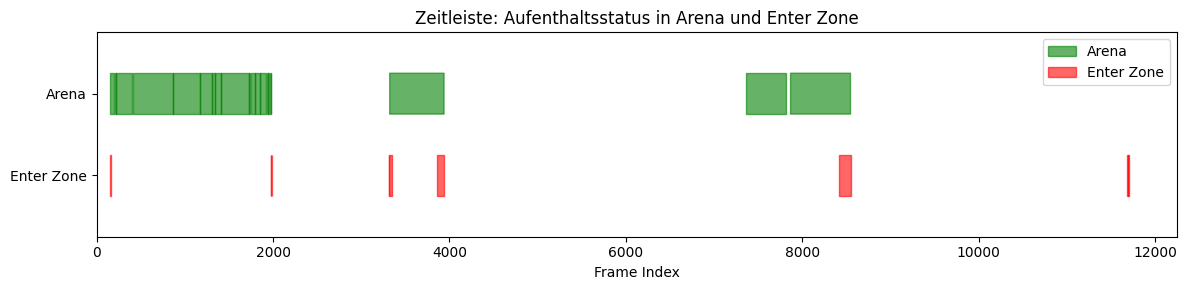

In [22]:
# Arrays in bool umwandeln (falls sie 0/1 sind)
#ez = mouse_in_enter_zone.astype(bool)
#ar = mouse_in_arena.astype(bool)

frames = np.arange(len(ez))

fig, ax = plt.subplots(figsize=(12, 3))

# Arena (grün, oben)
ax.fill_between(frames, 1.5, 2.0, where=ar, color='green', alpha=0.6, label='Arena')

# Enter Zone (rot, unten)
ax.fill_between(frames, 0.5, 1.0, where=ez, color='red', alpha=0.6, label='Enter Zone')

# Achsen formatieren
ax.set_ylim(0, 2.5)
ax.set_xlim(0, len(frames))
#alternative xlim
#ax.set_xlim(6400, 6900)
ax.set_yticks([0.75, 1.75])
ax.set_yticklabels(['Enter Zone', 'Arena'])
ax.set_xlabel("Frame Index")
ax.set_title("Zeitleiste: Aufenthaltsstatus in Arena und Enter Zone")
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

C:\Users\quicken\AppData\Local\Temp\ipykernel_23004\2021529148.py:11: RuntimeWarning: Mean of empty slice
  mean_x = np.nanmean(arr_x, axis=1)
C:\Users\quicken\AppData\Local\Temp\ipykernel_23004\2021529148.py:12: RuntimeWarning: Mean of empty slice
  mean_y = np.nanmean(arr_y, axis=1)


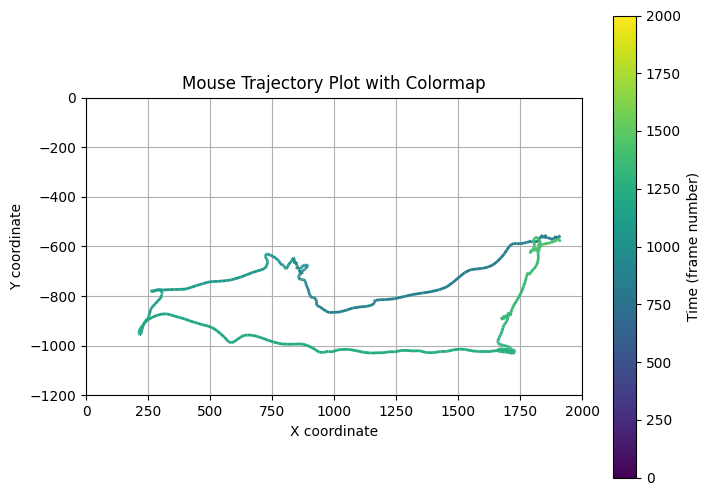

In [53]:
# trajectory plotten
# Plotten mit Colormap

import matplotlib.pyplot as plt
import matplotlib.collections as mc


arr_x = test_df.loc[:, (scorer, individuals[2], bodyparts, ["x", "y"])].values[:,::2]
arr_y = test_df.loc[:, (scorer, individuals[2], bodyparts, ["x", "y"])].values[:,1::2]

mean_x = np.nanmean(arr_x, axis=1)
mean_y = np.nanmean(arr_y, axis=1)

# Beispiel: Ihre Daten (bitte x_coords und y_coords entsprechend setzen)
x_coords = mean_x
y_coords = mean_y *-1

# ggf schneiden
x_coords = x_coords[2500:4500]
y_coords = y_coords[2500:4500]



# X- und Y-Koordinaten in Segmente aufteilen
points = np.array([x_coords, y_coords]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Colormap definieren
norm = plt.Normalize(0, len(x_coords))
lc = mc.LineCollection(segments, cmap='viridis', norm=norm)
lc.set_array(np.arange(len(x_coords)))
lc.set_linewidth(2)

# Plot erstellen
fig, ax = plt.subplots(figsize=(8, 6))
ax.add_collection(lc)
ax.set_xlim(0, 2000.0)
ax.set_ylim(-1200.0, 0)
ax.set_title("Mouse Trajectory Plot with Colormap")
ax.set_xlabel("X coordinate")
ax.set_ylabel("Y coordinate")
ax.grid(True)
ax.set_aspect('equal')

# Colorbar (optional)
cbar = plt.colorbar(lc, ax=ax)
cbar.set_label('Time (frame number)')

plt.savefig(r"C:\Users\quicken\Code\Ambros_analysis\code_test\mouse_3_trajectory_2500-4500.svg")
plt.show()